# Final project, Numerical Analysis 2018-2019


## Project description

In this project, we would like to compare the performance of some embarassingly simple algorithms to solve a classification problem based on the MNIST database. 

The abstract aim of the program is to write a function:

```
result = classify(image)
```

that takes as input a small grey scale image of a hand-written digit (from the MNIST database), and returns the digit corresponding to the content of the image.

An example of the images we'll be working on is the following:

![mnist examples](https://m-alcu.github.io/assets/mnist.png)

Some background on the MNIST database (from wikipedia):


## MNIST database

*From Wikipedia, the free encyclopedia*

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.

## MNIST sample images.

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. There have been a number of scientific papers on attempts to achieve the lowest error rate; one paper, using a hierarchical system of convolutional neural networks, manages to get an error rate on the MNIST database of 0.23%. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support vector machine to get an error rate of 0.8%. An extended dataset similar to MNIST called EMNIST has been published in 2017, which contains 240,000 training images, and 40,000 testing images of handwritten digits and characters.

## Algorithm

We start by defining the distance between two images. Ideally, a distance function between two images is zero when the images are the same, and greater than zero when the images are different. 

The bigger the distance, the more different the images should be. Ideally, the distance between an image of the number `9` should be closer to an image of the number `8` than to an image of the number `1` (the digits `9` and `8`, as images, differ by the fact that the first has one closed loop, while the second has two closed loops, while the digit `1` is mostly a straight line). Two different images representing the same number should be even closer (i.e., the distance function should return a "small" number).

Given a distance and a training set of images for which we know everything, the simplest algorithm we can think of to classify an image `z`, is the following: given a set of train images (`x_train`) for which we know the digit they represent (`y_train`), measure the distance between `z` and all images in `x_train`, and classify the image `z` to represent the same digit of the image that is closest to `z` in `x_train`:

Parameters of the algorithm:

- `x_train`
- `y_train`
- a distance function `dist`  

Input of the function

- `z`

Output of the function

- `digit`

where 

```
def classify(z):
    all_distances = array([dist(x, z) for x in x_train])
    digit = y_train[argmin(all_distances)]
    return digit
```

We will experiment with different distances, and we will try to improve the algorithm above in a step by step fashon.

## Data description

Each image in the MNIST dataset represents a hand written digit, in the form of a matrix of `28x28` values between zero and one, representing gray scale values (zero = white, one = black).

We use an array of `60.000x28x28` floating point values to collect all training images, and an array of `60.000` digits containing the (correct) value of the training digits (between 0 and 9 inclusive).

The testing images are instead collected into two arrays of size `10.000x28x28` and `10.0000` respectively.

In [1]:
%pylab inline

# input image dimensions
img_rows, img_cols = 28, 28

#Uncomment the following lines if you have keras installed. Otherwise you can 
# use the file I uploaded: mnist.npz
import keras
from keras.datasets import mnist
from keras import backend as K

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols)
    input_shape = (img_rows, img_cols)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

np.savez_compressed('mnist.npz', x_train, y_train, x_test, y_test)

arc = load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


# Plotting one image

How do we plot the images? `pyplot`, which has been imported by the first line of the previous cell, contains a command called `imshow`, that can be used to plot images. 

In this case we know it is a greyscale image, with zero representing white and one representing black, so we use a colormap that goes from white to black, i.e., `gray_r` where `_r` stands for reversed. 

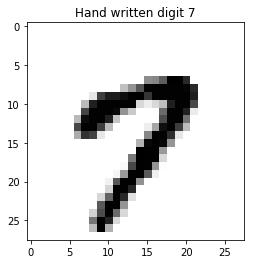

In [2]:
# Show image number 15, and write in the title what digit it should correspond to
N=15
imshow(x_train[N], cmap='gray_r')
_ = title('Hand written digit '+str(y_train[N]))

In [3]:
# Decorator to measure time

#adapted from Fluent Python and Magister Alberto
import functools
def args_to_string(*args,**kw):
    arg_str = []
    if args:
        arg_str.append(','.join(str(arg) for arg in args))
    if kw:
        arg_str.append(', '.join(('{0}={1}'.format(k,v) for k,v in kw.items())))
    return ','.join(a for a in arg_str)

import time
def time_this(func):
    def decorated(*args,**kw):
        t0 = time.perf_counter()
        result = func(*args,**kw)
        t1 = time.perf_counter()
        name = func.__name__
        #arg_str = args_to_string(*args,**kw)
        #print('{0}({1}): [{2}]'.format(name, arg_str,t1-t0))
        #print('{}({}): [{}]'.format(name, arg_str,t1-t0))
        print('%s: [%0.8fs]' % (name, t1-t0))
        return result
    return decorated


class Timer():
    def __init__(self):
        self._start = 0
    def __enter__(self):
        self._start = time.time()
        return self	

    def __exit__(self, exc_type, exc_value, traceback):
        print("Total time = ", time.time() - self._start) 
        return True

**IF YOU DON'T HAVE ENOUGH COMPUTATIONAL POWER, RUN THE EXERCISES ONLY UP TO WHAT IS SUSTAINABLE FOR YOUR PC**

General guidelines:

- Time all functions you construct, and try to make them run as fast as possible by precomputing anything that can be precomputed
- Extra points are gained if you reduce the complexity of the given algorithms in any possible way, for example by exploiting linearity, etc.
- If something takes too long to execute, make sure you time it on a smaller set of input data, and give estimates of how long it would take to run the full thing (without actually running it). Plot only the results you manage to run on your PC.

# Assignment 1

Implement the following distance functions

- d_infty $$ d_{\infty}(a,b) := \max_{i,j} |b_{ij}-a_{ij}|$$
- d_one $$ d_1(a,b) := \sum_{i,j} |b_{ij}-a_{ij}|$$
- d_two $$ d_2(a,b) := \sqrt{\sum_{i,j} |b_{ij}-a_{ij}|^2}$$

that take two `(28,28)` images in input, and return a non-negative number.

In [4]:
def d_infty(a, b):
    return np.max(abs(b - a))

def d_one(a, b):
    return np.sum(np.abs(a - b))

def d_two(a, b):
    return np.sqrt(np.sum(np.square(b - a)))

# try
print(d_infty(x_train[2], x_train[3]))
print(d_one(x_train[2], x_train[3]))
print(d_two(x_train[2], x_train[3]))

1.0
125.60784
10.084714


# Assignment 2

Write a function that, given a number `N`, and a distance function `dist`, computes the distance matrix D of shape `(N,N)` between the first `N` entries of `x_train`:

```
D[i,j] = dist(x_train[i], x_train[j])
```

performing the **minimum** number of operations (i.e., avoid computing a distance if it has already been computed before, i.e., keep in mind that dist(a,b) = dist(b,a)).

In [5]:
def distance(N, dist, dataset, **kwargs):
    x_dist = dataset[:N]
    D = zeros((N,N))
    
    if bool(kwargs):
        for i in range(N):
            for j in range(i, N):
                D[i][j] = dist(x_dist[i], x_dist[j], id_f1 = i, id_f2 = j, **kwargs)
    else:
        for i in range(N):
            for j in range(i, N):
                D[i][j] = dist(x_dist[i], x_dist[j])
    return D + D.T

print(distance(4,d_two, x_train))
print(distance(4, d_one, x_train))

[[ 0.          9.36122227 10.87509441 10.01890182]
 [ 9.36122227  0.         11.36836433 10.849123  ]
 [10.87509441 11.36836433  0.         10.08471394]
 [10.01890182 10.849123   10.08471394  0.        ]]
[[  0.         115.70979309 148.50196838 122.61177063]
 [115.70979309   0.         160.91764832 141.45881653]
 [148.50196838 160.91764832   0.         125.60784149]
 [122.61177063 141.45881653 125.60784149   0.        ]]


# Assignment 3

Compute and plot the three distance matrices

- Dinfty
- D1
- D2

for the first 100 images of the training set, using the function `imshow` applied to the three matrices

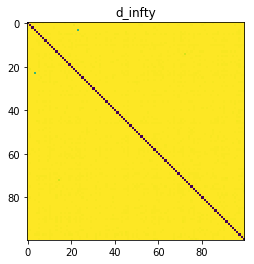

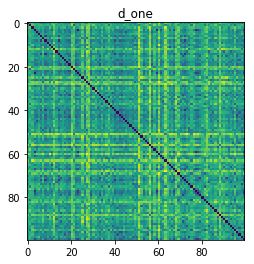

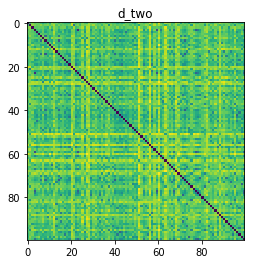

In [6]:
import matplotlib.pyplot as plt

N = 100

plt.imshow(distance(N, d_infty, x_train), cmap = 'viridis')
_ = title('d_infty')
plt.show()

plt.imshow(distance(N, d_one, x_train), cmap = 'viridis')
_ = title('d_one')
plt.show()

plt.imshow(distance(N, d_two, x_train), cmap = 'viridis')
_ = title('d_two')
plt.show()

# Assignment 4

Using only a distance matrix, apply the algorithm described above and compute the efficency of the algorithm, i.e., write a function that:

Given a distance matrix with shape `(N,N)`, constructed on the first `N` samples of the `x_train` set, count the number of failures of the **leave one out** strategy, i.e., 

- set `error_counter` to zero

- for every line `i` of the matrix:

    - find the index `j` (different from `i`) for which `D[i,k] >= D[i,j]` for all `k` different from `i` and `j`.

    - if `y_train[j]` is different from `y_train[i]`, increment by one `error_counter`

- return the error: error_counter/N

- apply the function above to the 3 different distance matrices you computed before

In [7]:
N = 200
D_infty = distance(N, d_infty, x_train)
D_one = distance(N, d_one, x_train)
D_two = distance(N, d_two, x_train)

##@time_this
def efficiency(N, D):
    errors = 0
    for i in range(N):
        D[i, i] = D[i, i-1]
        min_i = np.argmin(D[i])
        D[i, i] = 0
        
        if not y_train[i] == y_train[min_i]: errors = errors + 1
    return errors/N

print('D_infty efficiency: ', efficiency(N, D_infty))
print('D_one efficiency: ', efficiency(N, D_one))
print('D_two efficiency: ', efficiency(N, D_two))

D_infty efficiency:  0.52
D_one efficiency:  0.145
D_two efficiency:  0.135


# Assignment 5

Run the algorithm implemented above for N=100,200,400,800,1600 on the three different distances, and plot the three error rate as a function of N (i.e., compute the distance matrix, and compute the efficiency associated to the distance matrix).

You should get an error like:
```
[[ 0.58      0.17      0.17    ]
 [ 0.52      0.145     0.135   ]
 [ 0.4425    0.15      0.135   ]
 [ 0.4       0.145     0.12875 ]
 [ 0.369375  0.1025    0.09375 ]]
```
where each column represents a different norm.

** In the next assignments, optional points are given if you manage to make the algorithm run faster, by pre-computing everything you can precompute in advance **

Total time =  41.92960596084595


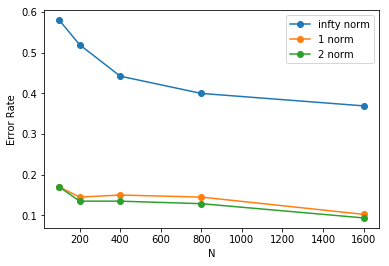

In [8]:
sizes = np.array([100, 200, 400, 800, 1600])

with Timer() as t:
    errors_dinfty = [efficiency(N, distance(N, d_infty, x_train)) for N in sizes]
    errors_one = [efficiency(N, distance(N, d_one, x_train)) for N in sizes]
    errors_two = [efficiency(N, distance(N, d_two, x_train)) for N in sizes]

#print(errors_dinfty)

plt.plot(sizes, errors_dinfty, '-o', label = 'infty norm')
plt.plot(sizes, errors_one, '-o', label = '1 norm')
plt.plot(sizes, errors_two, '-o', label = '2 norm')
plt.legend()
plt.xlabel('N')
plt.ylabel('Error Rate')
plt.show()

# Assignment 6

In principle, it should be possible to decrease the error by using a better norm. From the table above, it is clear that the L2 distance works better than the L1 distance, which works better than the Linfty distance.

However, *none of these distances exploit the fact that the image is a two-dimensional object*, and that there is information also in the **neighboring** information of the pixels. 

One way to exploit this, is to interpret the image as a continuous function with values between zero and one, defined on a square domain `\Omega=[0,27]x[0,27]`.

$$ f: \Omega \to R $$

- Implement a function that computes an approximation of the $H^1$ norm distance on the renormalized images. Given two images $f_1$ and $f_2$
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Define the $H^1$ distance as
    $$
    d_{H^1}(f_1,f_2) := \sqrt{\int_\Omega |\nabla(a-b)|^2+ (a-b)^2}
    $$
    using the algorithm you prefer (or the library you prefer) to compute the gradients and the integrals. Notice that $\nabla f = (\partial f/\partial x, \partial f/\partial y)$ is a vector valued function, and $|\nabla g|^2 := (\partial g/\partial x)^2 + (\partial g/\partial y)^2$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600

In [9]:
from scipy.integrate import simps

def gradients_list(data):
    gradient = [np.gradient(img) for img in data]
    return gradient

def integrals_list(data):
    x = np.arange((data[0].shape[0]))
    y = np.arange((data[0].shape[1]))
    
    integrals = [simps(simps(img, y), x) for img in data]
    return integrals

grads = gradients_list(x_train)
intgrls = integrals_list(x_train)

In [10]:
def d_h1(f1, f2, **kwargs):
    '''you can input f1 and f2's indexes, 
        and the gradients' array.
        This comes useful to set the indexes'''
    
    img1 = kwargs['id_f1']
    img2 = kwargs['id_f2']
    grads_arr = kwargs['grads_arr']
    
    x = np.arange(x_train[0].shape[0])
    y = np.arange(x_train[0].shape[1])
    
    a = f1 / intgrls[img1]
    b = f2 / intgrls[img2]
    
    ab_gradient = (grads_arr[img1]/intgrls[img1] \
                  - grads_arr[img2]/intgrls[img2])
    ab_grad_absqr = np.square(ab_gradient[0]) + np.square(ab_gradient[1])
    ab_sq = np.square(a - b)
    
    
    return np.sqrt(simps(simps(ab_grad_absqr + ab_sq, y), x))

print(d_h1(x_train[23], x_train[24], id_f1 = 23, id_f2=24, grads_arr = grads))

0.15728125996915043


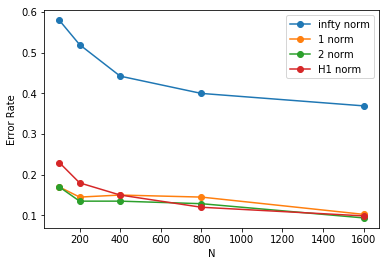

In [11]:
sizes = np.array([100, 200, 400, 800, 1600])

errors_dh1 = [efficiency(size, distance(size, d_h1, x_train, grads_arr = grads)) for size in sizes]

plt.plot(sizes, errors_dinfty, '-o', label = 'infty norm')
plt.plot(sizes, errors_one, '-o', label = '1 norm')
plt.plot(sizes, errors_two, '-o', label = '2 norm')
plt.plot(sizes, errors_dh1, '-o', label = 'H1 norm')
plt.legend()
plt.xlabel('N')
plt.ylabel('Error Rate')
plt.show()

## Assignment 7

An even better improvement on the previous distance function is given by the following algorithm

- Given two images $f1$ and $f2$:
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Solve 
    $$
    -\Delta \phi = a - b \qquad \text{ in } \Omega
    $$
    $$
    \phi = 0 \text{ on } \partial\Omega
    $$
    - Define the *Monge Ampere* distance
    $$
    d_{MA}(f_1,f_2) = \int_\Omega (a+b)|\nabla \phi|^2
    $$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600

## Assigment 8 (optional for DSSC, PhD and LM, Mandatory for MHPC)

Use the `BallTree` algorithm (https://en.wikipedia.org/wiki/Ball_tree), from the `sklearn` package, and construct a tree data structure **that uses one of the custom distances defined above**.

For each N in 3200,6400,12800,25600,51200, and for each distance defined above

- Build a tree using the first N entries of the training set `x_train`
- Construct a function that tests the efficiency on all the entries of the test set `x_test`:
    - for any image in `x_test`, call it `x_test[i]`, query the tree for the nearest neighbor (call it `k`), and assign as predicted digit the digit of the `x_train[k]` image, i.e., `y_train[k]`
    - check if `y_train[k]` is equal to the corresponding entry in `y_test[i]`. If not, increment a counter of the error
    - return the efficiency, i.e., `error_counter/len(x_test)`
- Plot, in a single graph, the error of each distance as a function of `N` (including labels, titles, etc.)

- Once you have the tree, experiment with different nearest neighbor algorithms, i.e., instead of taking only one nearest neighbor, take a larger number (a small number of your choice), and instead of returning the single closest digit, return the one with the largest number of occurrences. Plot the same graph you gave before, and see if you gain an improvement. Motivate all choices you have to make to get to the final answer.


**IF YOU DON'T HAVE ENOUGH COMPUTATIONAL POWER, RUN THE EXERCISES ONLY UP TO WHAT IS SUSTAINABLE FOR YOUR PC**

In [12]:
from sklearn.neighbors import BallTree

In [13]:
N = 1000

# Need to reshape x_train due to BallTree's implementation
ball_train = x_train[:N].reshape(N, 28*28)
#x_train = x_train[:N].reshape(N, 28*28)
ball_train.shape



(1000, 784)

In [14]:
# Need to modify d_h1() based on BallTree's metric's implementation

def d_h1_btree(f1, f2):
    
    f1 = f1.reshape(28, 28)
    f2 = f2.reshape(28, 28)
    
    x = np.arange(x_train[0].shape[0])
    y = np.arange(x_train[0].shape[1])
    
    f1_intg = simps(simps(f1, y), x)
    f2_intg = simps(simps(f2, y), x)
    
    a = f1 / f1_intg
    b = f2 / f2_intg
    
    ab_gradient = np.gradient(a - b)
    ab_grad_absqr = np.square(ab_gradient[0]) + np.square(ab_gradient[1])
    ab_sq = np.square(a - b)
    
    
    return np.sqrt(simps(simps(ab_grad_absqr + ab_sq, y), x))

In [15]:
def k_nbgh(knn, size, dist_func, train_data, train_labels, test_data, test_labels, **kwargs):

    tree = BallTree(train_data[:size].reshape(size, 28*28), leaf_size = 300, metric = dist_func, **kwargs)
    dist, ind = tree.query(test_data[:size].reshape(size, 28*28), k = knn)
    return ind, dist

In [16]:
def tree_efficiency(knn, size, dist_func, train_data, train_labels, test_data, test_labels, **kwargs):
    
    ind, _ = k_nbgh(knn, size, dist_func, train_data, train_labels, test_data, test_labels, **kwargs)
    k_nbgh_lab = np.array([[train_labels[ind[i, j]] for j in range(knn)] for i in arange(size)])
    
    errors = 0
    for img in range(size):
        counter = np.bincount(k_nbgh_lab[img,:])
        if not test_labels[img] == np.argmax(counter): errors += 1
    return [knn, size, errors/size]

In [17]:
knns = [2, 4, 8]
sizes = np.array([100, 200, 400, 800])

errs_dinfty = np.array([tree_efficiency(knn, N, d_infty, x_train, y_train, x_test, y_test) for knn in knns for N in sizes])
errs_one = np.array([tree_efficiency(knn, N, d_one, x_train, y_train, x_test, y_test) for knn in knns for N in sizes])
errs_two = np.array([tree_efficiency(knn, N, d_two, x_train, y_train, x_test, y_test) for knn in knns for N in sizes])
errs_h1_btree = np.array([tree_efficiency(knn, N, d_h1_btree, x_train, y_train, x_test, y_test) for knn in knns for N in sizes])

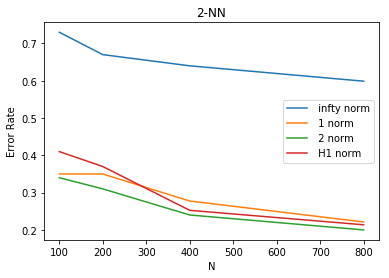

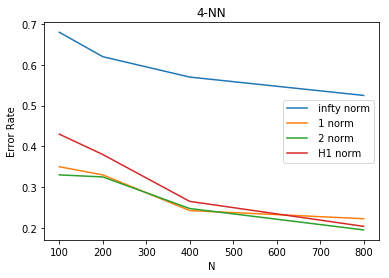

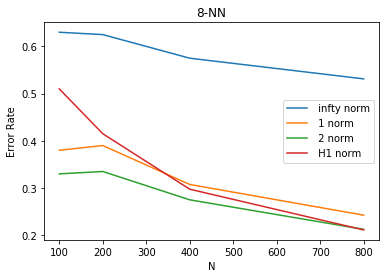

In [18]:
# plots for k-nn = 2, 4, 8

for k in range(3):
    plot(sizes, errs_dinfty[len(sizes)*k:len(sizes)*(k+1), 2], label = ' infty norm')
    plot(sizes, errs_one[len(sizes)*k:len(sizes)*(k+1), 2], label = ' 1 norm')    
    plot(sizes, errs_two[len(sizes)*k:len(sizes)*(k+1), 2], label = ' 2 norm')
    plot(sizes, errs_h1_btree[len(sizes)*k:len(sizes)*(k+1), 2], label = ' H1 norm')    
    plt.legend()
    plt.title(str(knns[k]) + '-NN')
    plt.xlabel('N')
    plt.ylabel('Error Rate')
    plt.show()